In [20]:
import torch
import torch.nn as nn
import numpy as np
from gensim.models import KeyedVectors
from main_biLSTM import run
from torchcrf import CRF

In [21]:
# ! pip install torchcrf

In [22]:
# ! pip install torch torchvision torchaudio --upgrade

In [23]:
# ! pip install --upgrade torch

In [24]:
# import warnings

# warnings.filterwarnings("ignore", category=UserWarning)

In [25]:
def load_glove_embeddings(file_path, word_to_index, embedding_dim):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings[word] = coefs

    num_words = len(word_to_index)+1  # add 1 for the padding token
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, index in word_to_index.items():
        if (embedding := embeddings.get(word)) is not None:
            embedding_matrix[index] = embedding
        else:
            embedding_matrix[index] = embeddings.get("<unk>", np.zeros(embedding_dim))

    return embedding_matrix

In [26]:
def load_word2vec_embeddings(file_path, word_to_index, embedding_dim):
    model = KeyedVectors.load_word2vec_format(file_path, binary=True)
    embedding_matrix = np.zeros((len(word_to_index) + 1, embedding_dim))

    for word, index in word_to_index.items():
        embedding_matrix[index] = model[word] if word in model else np.zeros(embedding_dim)

    return embedding_matrix

In [27]:
def load_fasttext_embeddings(embedding_file, word_index, embedding_dim):
    embeddings_index = {}
    with open(embedding_file, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [28]:
class BiLSTMCRF(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, output_size, embedding_dim):
        super(BiLSTMCRF, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0)
        self.bilstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, 
                              batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.crf = CRF(output_size, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.bilstm(x)
        logits = self.fc(lstm_out)
        return logits
    def calculate_crf_loss(self, emissions, tags):
        return -self.crf(emissions, tags)

In [29]:
run(load_glove_embeddings, 300, "../word_embeddings/glove.6B.300d.txt", BiLSTMCRF, "biLSTM_glove",60)

Epoch: 100/100
Validation Loss: 0.1330
Validation Macro F1: 0.7547
Training Macro F1: 0.9994


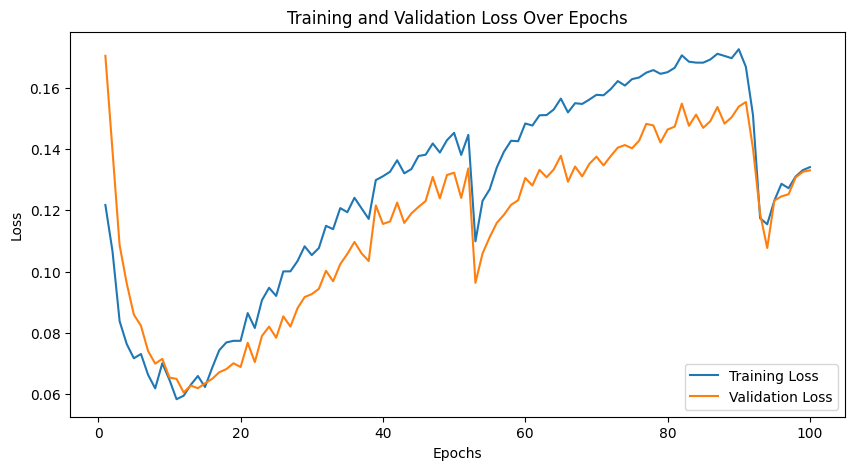

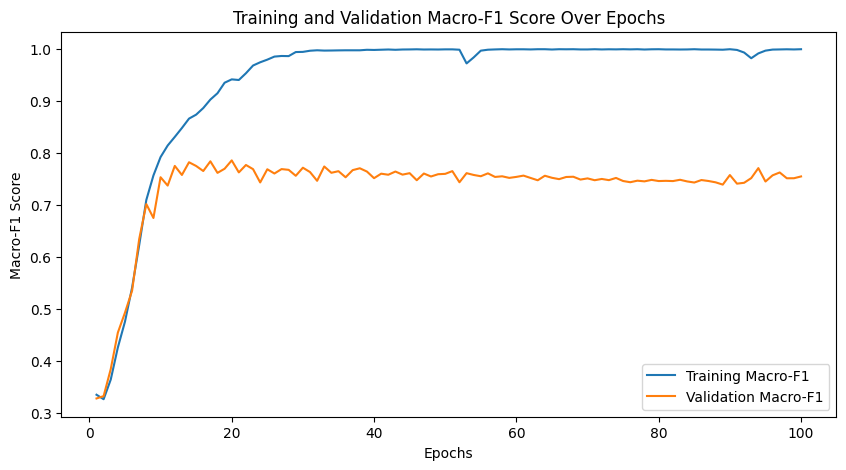

Final Test Accuracy: 0.9729
Final Test Macro F1: 0.7260
Classification Report for Test Data:
               precision    recall  f1-score   support

           O       0.98      0.99      0.99     14774
           B       0.72      0.60      0.65       463
           I       0.86      0.39      0.54       243

    accuracy                           0.97     15480
   macro avg       0.85      0.66      0.73     15480
weighted avg       0.97      0.97      0.97     15480



In [ ]:
run(load_word2vec_embeddings, 300, "../word_embeddings/GoogleNews-vectors-negative300.bin", BiLSTMCRF, "biLSTM_word2vec",100)

In [ ]:
run(load_fasttext_embeddings, 300, "../word_embeddings/wiki-news-300d-1M.vec", BiLSTMCRF, "biLSTM_fasttext",60)